<a href="https://colab.research.google.com/github/ekrell/geoscience-attribution-benchmarks/blob/main/benchmarks/gen_rasters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as ndimage

## Functions for generating random rasters

In [2]:
def filterBounds(coords_list, max_x, max_y, max_z, min_x=0, min_y=0, min_z=0):
  mins = (min_x, min_y, min_z)
  maxs = (max_x, max_y, max_z)
  a = coords_list
  return a[(a >= mins).all(axis=1) & (a <= maxs).all(axis=1)]


def grow(raster, mask, coords, threshold, decay, point_value, point_value_dist=0):

  # Adjust 2D data to be 3D (with one band)
  if len(raster.shape) == 2:
    raster = np.reshape(raster, (raster.shape[0], raster.shape[1], 1))
    mask = np.reshape(mask, (raster.shape[0], raster.shape[1], 1))
    coords = (coords[0], coords[1], 0)

  if mask[coords[0], coords[1], coords[2]] != 0:
    return
  mask[coords[0], coords[1], coords[2]] = 1.0

  sample = np.random.rand()
  if sample <= threshold:
    raster[coords[0], coords[1], coords[2]] = point_value + np.random.uniform(-1 * point_value_dist, point_value_dist)
  else:
    return

  neighbors = np.array([
      (coords[0] - 1, coords[1], coords[2]),
      (coords[0] + 1, coords[1], coords[2]),
      (coords[0], coords[1] - 1, coords[2]),
      (coords[0], coords[1] + 1, coords[2]),
      (coords[0] - 1, coords[1], coords[2] - 1),
      (coords[0] + 1, coords[1], coords[2] - 1),
      (coords[0], coords[1] - 1, coords[2] - 1),
      (coords[0], coords[1] + 1, coords[2] - 1),
      (coords[0] - 1, coords[1], coords[2] + 1),
      (coords[0] + 1, coords[1], coords[2] + 1),
      (coords[0], coords[1] - 1, coords[2] + 1),
      (coords[0], coords[1] + 1, coords[2] + 1),
  ])
  valid_neighbors = filterBounds(neighbors, raster.shape[1] - 1, raster.shape[0] - 1, raster.shape[2] - 1)
  for vn in valid_neighbors:
    grow(raster, mask, vn, threshold - decay, decay, point_value, point_value_dist)

## Example 1: Solid-Color Shapes

In [3]:
# Define raster
rows = 50
cols = 50

# Define placement seeds
seeds = [
    {"coords": (10, 10), "value": 0.2, "threshold": 0.9, "decay": 0.01, "value_dist": 0.2},
    {"coords": (20, 20), "value": 0.6, "threshold": 0.9, "decay": 0.01, "value_dist": 0.1},
    {"coords": (40, 20), "value": 0.8, "threshold": 0.9, "decay": 0.01, "value_dist": 0.3},
]

In [4]:
n_samples = 6
rasters = np.zeros((n_samples, rows, cols))
for i in range(n_samples):
  mask = rasters[i].copy()
  for seed in seeds:
    grow(rasters[i], mask, seed["coords"], seed["threshold"], seed["decay"], seed["value"])

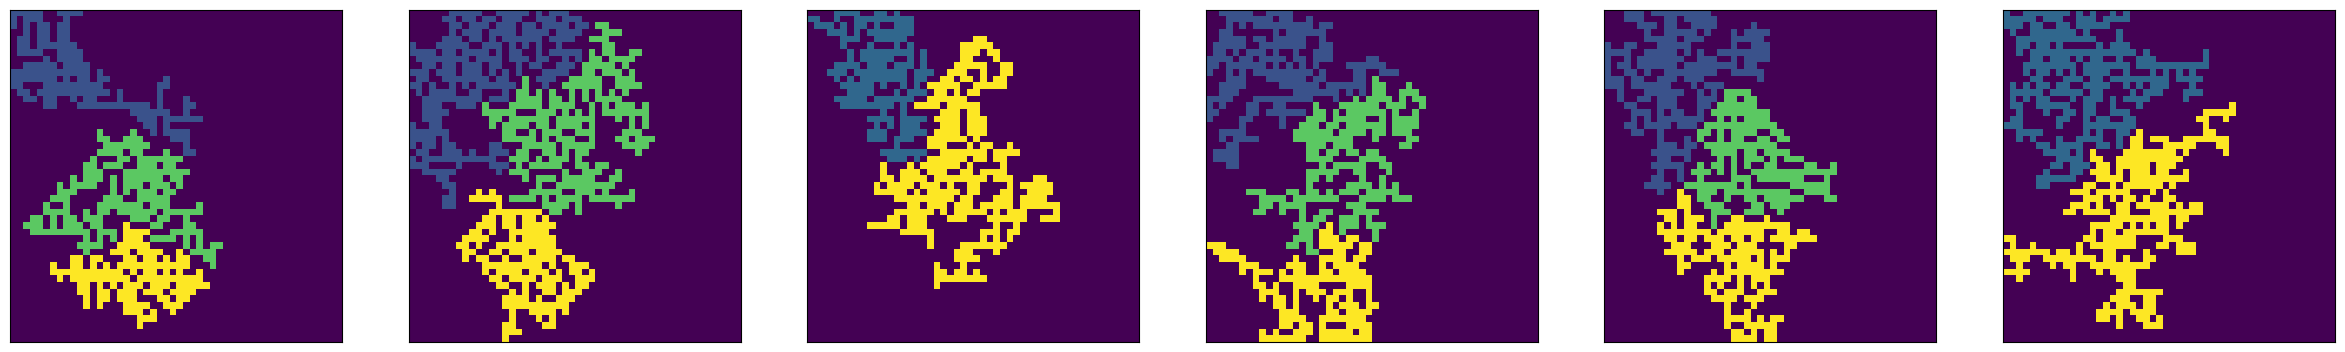

In [5]:
fig, axs = plt.subplots(1, n_samples, figsize=(n_samples * 5, 5))
for i in range(n_samples):
  axs[i].imshow(rasters[i])
  axs[i].set_yticks([])
  axs[i].set_xticks([])

## Example 2: S-Color Shapes + Dilation

In [6]:
dilations = [ndimage.grey_dilation(raster, size=(2, 2), structure=np.ones((2, 2))) for raster in rasters]

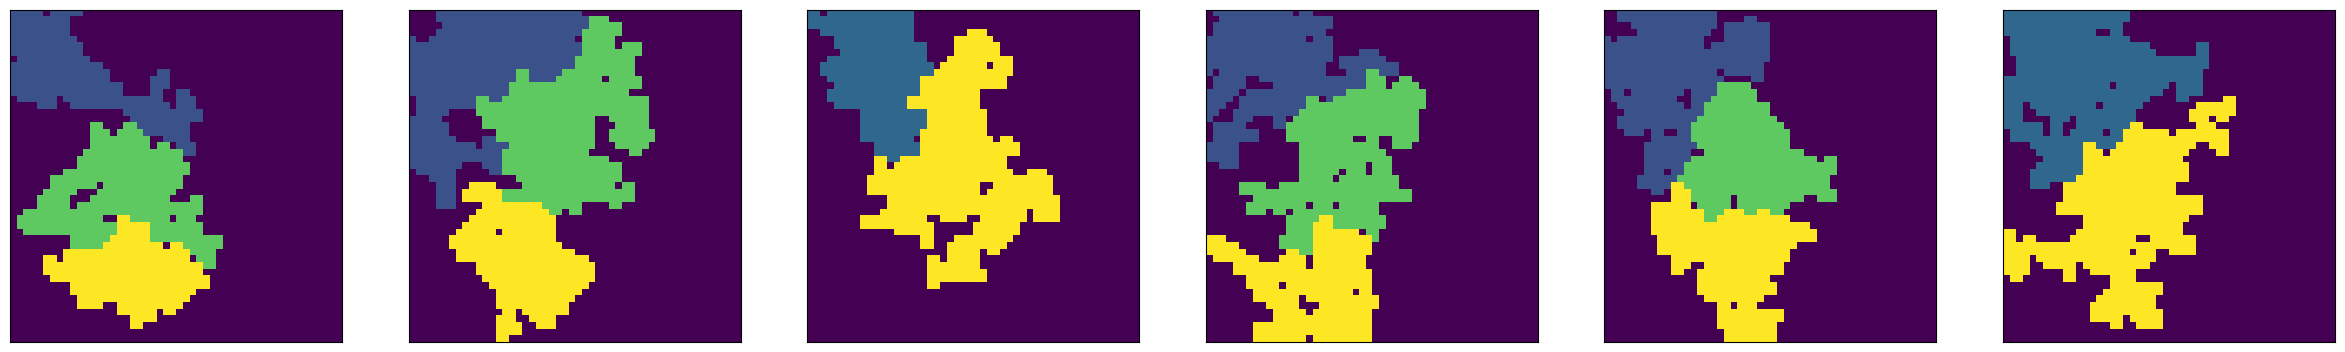

In [7]:
fig, axs = plt.subplots(1, n_samples, figsize=(n_samples * 5, 5))
for i in range(n_samples):
  axs[i].imshow(dilations[i])
  axs[i].set_yticks([])
  axs[i].set_xticks([])

## Example 3: Fuzzy-Color Shapes

In [8]:
rasters = np.zeros((n_samples, rows, cols))
for i in range(n_samples):
  mask = rasters[i].copy()
  for seed in seeds:
    grow(rasters[i], mask, seed["coords"], seed["threshold"], seed["decay"], seed["value"], seed["value_dist"])

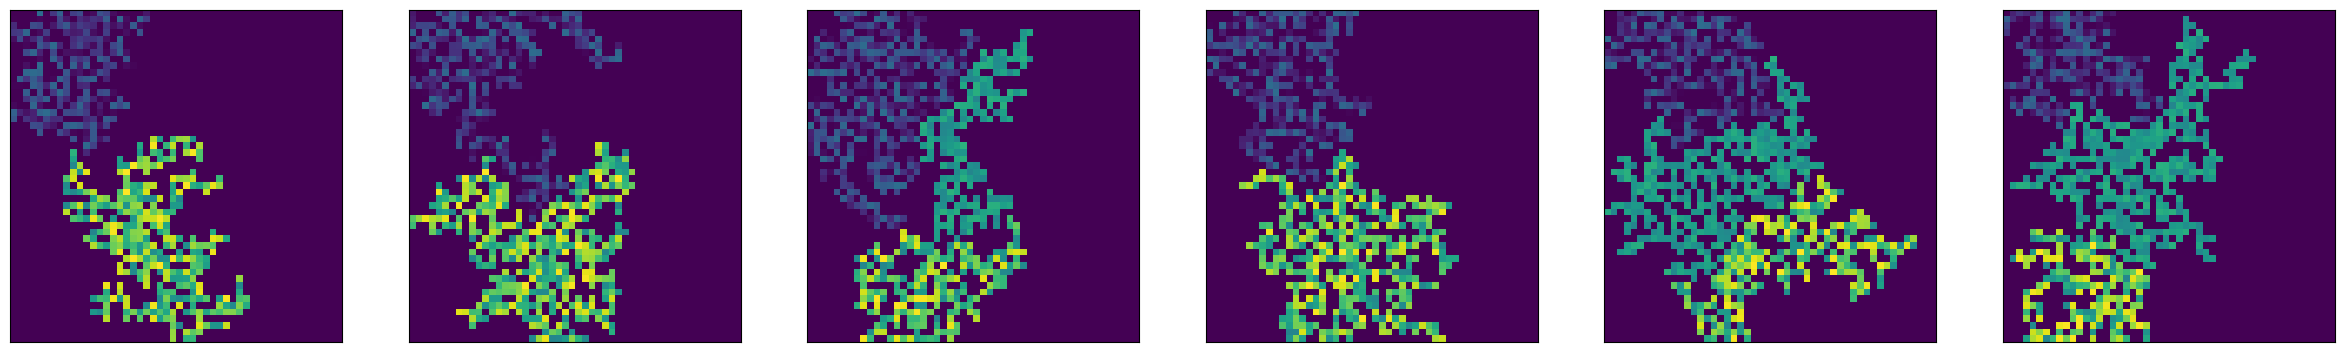

In [9]:
fig, axs = plt.subplots(1, n_samples, figsize=(n_samples * 5, 5))
for i in range(n_samples):
  axs[i].imshow(rasters[i])
  axs[i].set_yticks([])
  axs[i].set_xticks([])

## Example 4: Fuzzy-Color Shapes + Guassian

In [10]:
guassians = [ndimage.gaussian_filter(raster, sigma=0.75) for raster in rasters]

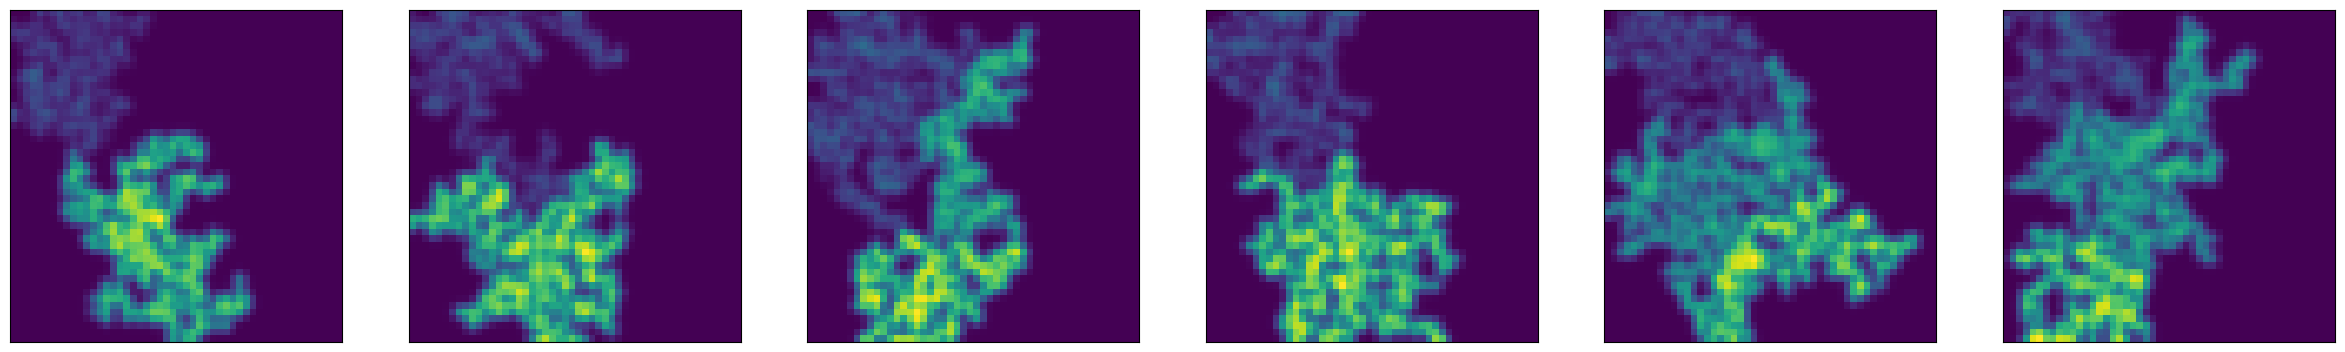

In [11]:
fig, axs = plt.subplots(1, n_samples, figsize=(n_samples * 5, 5))
for i in range(n_samples):
  axs[i].imshow(guassians[i])
  axs[i].set_yticks([])
  axs[i].set_xticks([])

## Example 5: Time Series

Each pixel is randomly shifted towards a given direction

In [12]:
# Specify movement vector
move_dir_deg = 20
move_mag_px = 6

# Convert from degrees to radians
move_dir_rad = np.radians(move_dir_deg)
# Convert to vector components
u = move_mag_px * np.cos(move_dir_rad)
v = move_mag_px * np.sin(move_dir_rad)

def shiftCells(raster, u, v):
  rows = raster.shape[0]
  cols = raster.shape[1]

  raster_out = np.zeros((rows, cols))

  for row in range(rows):
    for col in range(cols):
       # Calculate new point based on current point and vector
       row_new = int(row + u)
       col_new = int(col + v)
       # Shift to new point
       if row_new > 0 and row_new < rows and col_new > 0 and col_new < cols:
         raster_out[row_new, col_new] = raster[row, col]

  return raster_out

In [13]:
n_shifts = 4

shifted = np.zeros((n_shifts, len(guassians), rows, cols))
for j in range(len(guassians)):
  shifted[0, j, :, :] = guassians[j].copy()
  for i in range(1, n_shifts):
    shifted[i,j,:,:] = shiftCells(shifted[i-1, j, :, :], u, v)


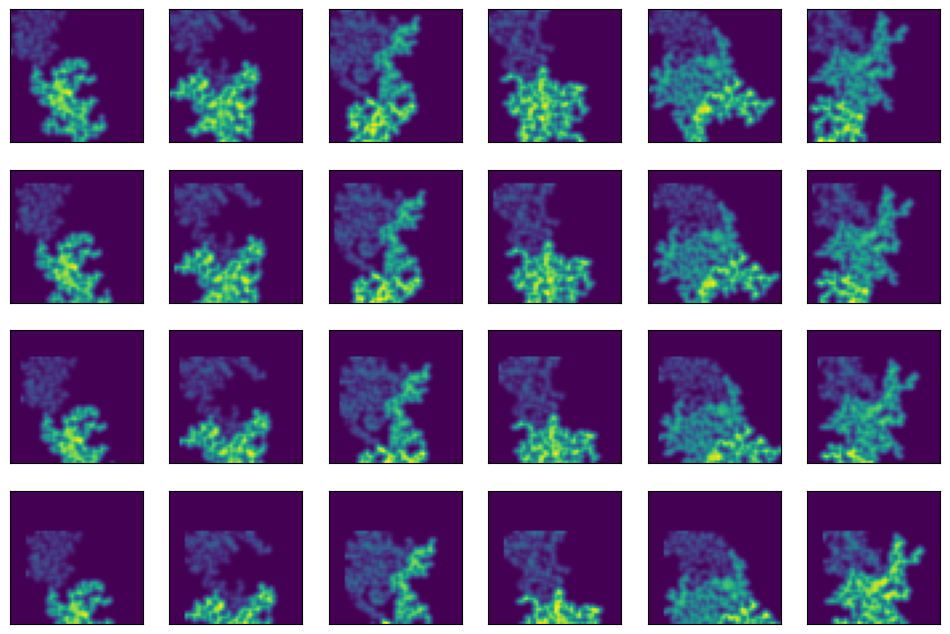

In [14]:
fig, axs = plt.subplots(n_shifts, len(guassians), figsize=(n_samples * 2, n_shifts * 2))
for i in range(n_shifts):
  for j in range(len(guassians)):
    axs[i, j].imshow(shifted[i, j, :, :])
    axs[i, j].set_yticks([])
    axs[i, j].set_xticks([])

## Example 6: 3D Solid-Color Shapes

In [15]:
# Define raster
rows = 50
cols = 50
bands = 10

# Define placement seeds
seeds = [
    {"coords": (10, 10, 0), "value": 0.2, "threshold": 0.9, "decay": 0.01, "value_dist": 0.2},
    {"coords": (20, 20, 1), "value": 0.6, "threshold": 0.9, "decay": 0.01, "value_dist": 0.1},
    {"coords": (40, 20, 2), "value": 0.8, "threshold": 0.9, "decay": 0.01, "value_dist": 0.3},
]

In [16]:
n_samples = 6
rasters = np.zeros((n_samples, rows, cols, bands))
for i in range(n_samples):
  mask = rasters[i].copy()
  for seed in seeds:
    grow(rasters[i], mask, seed["coords"], seed["threshold"], seed["decay"], seed["value"])

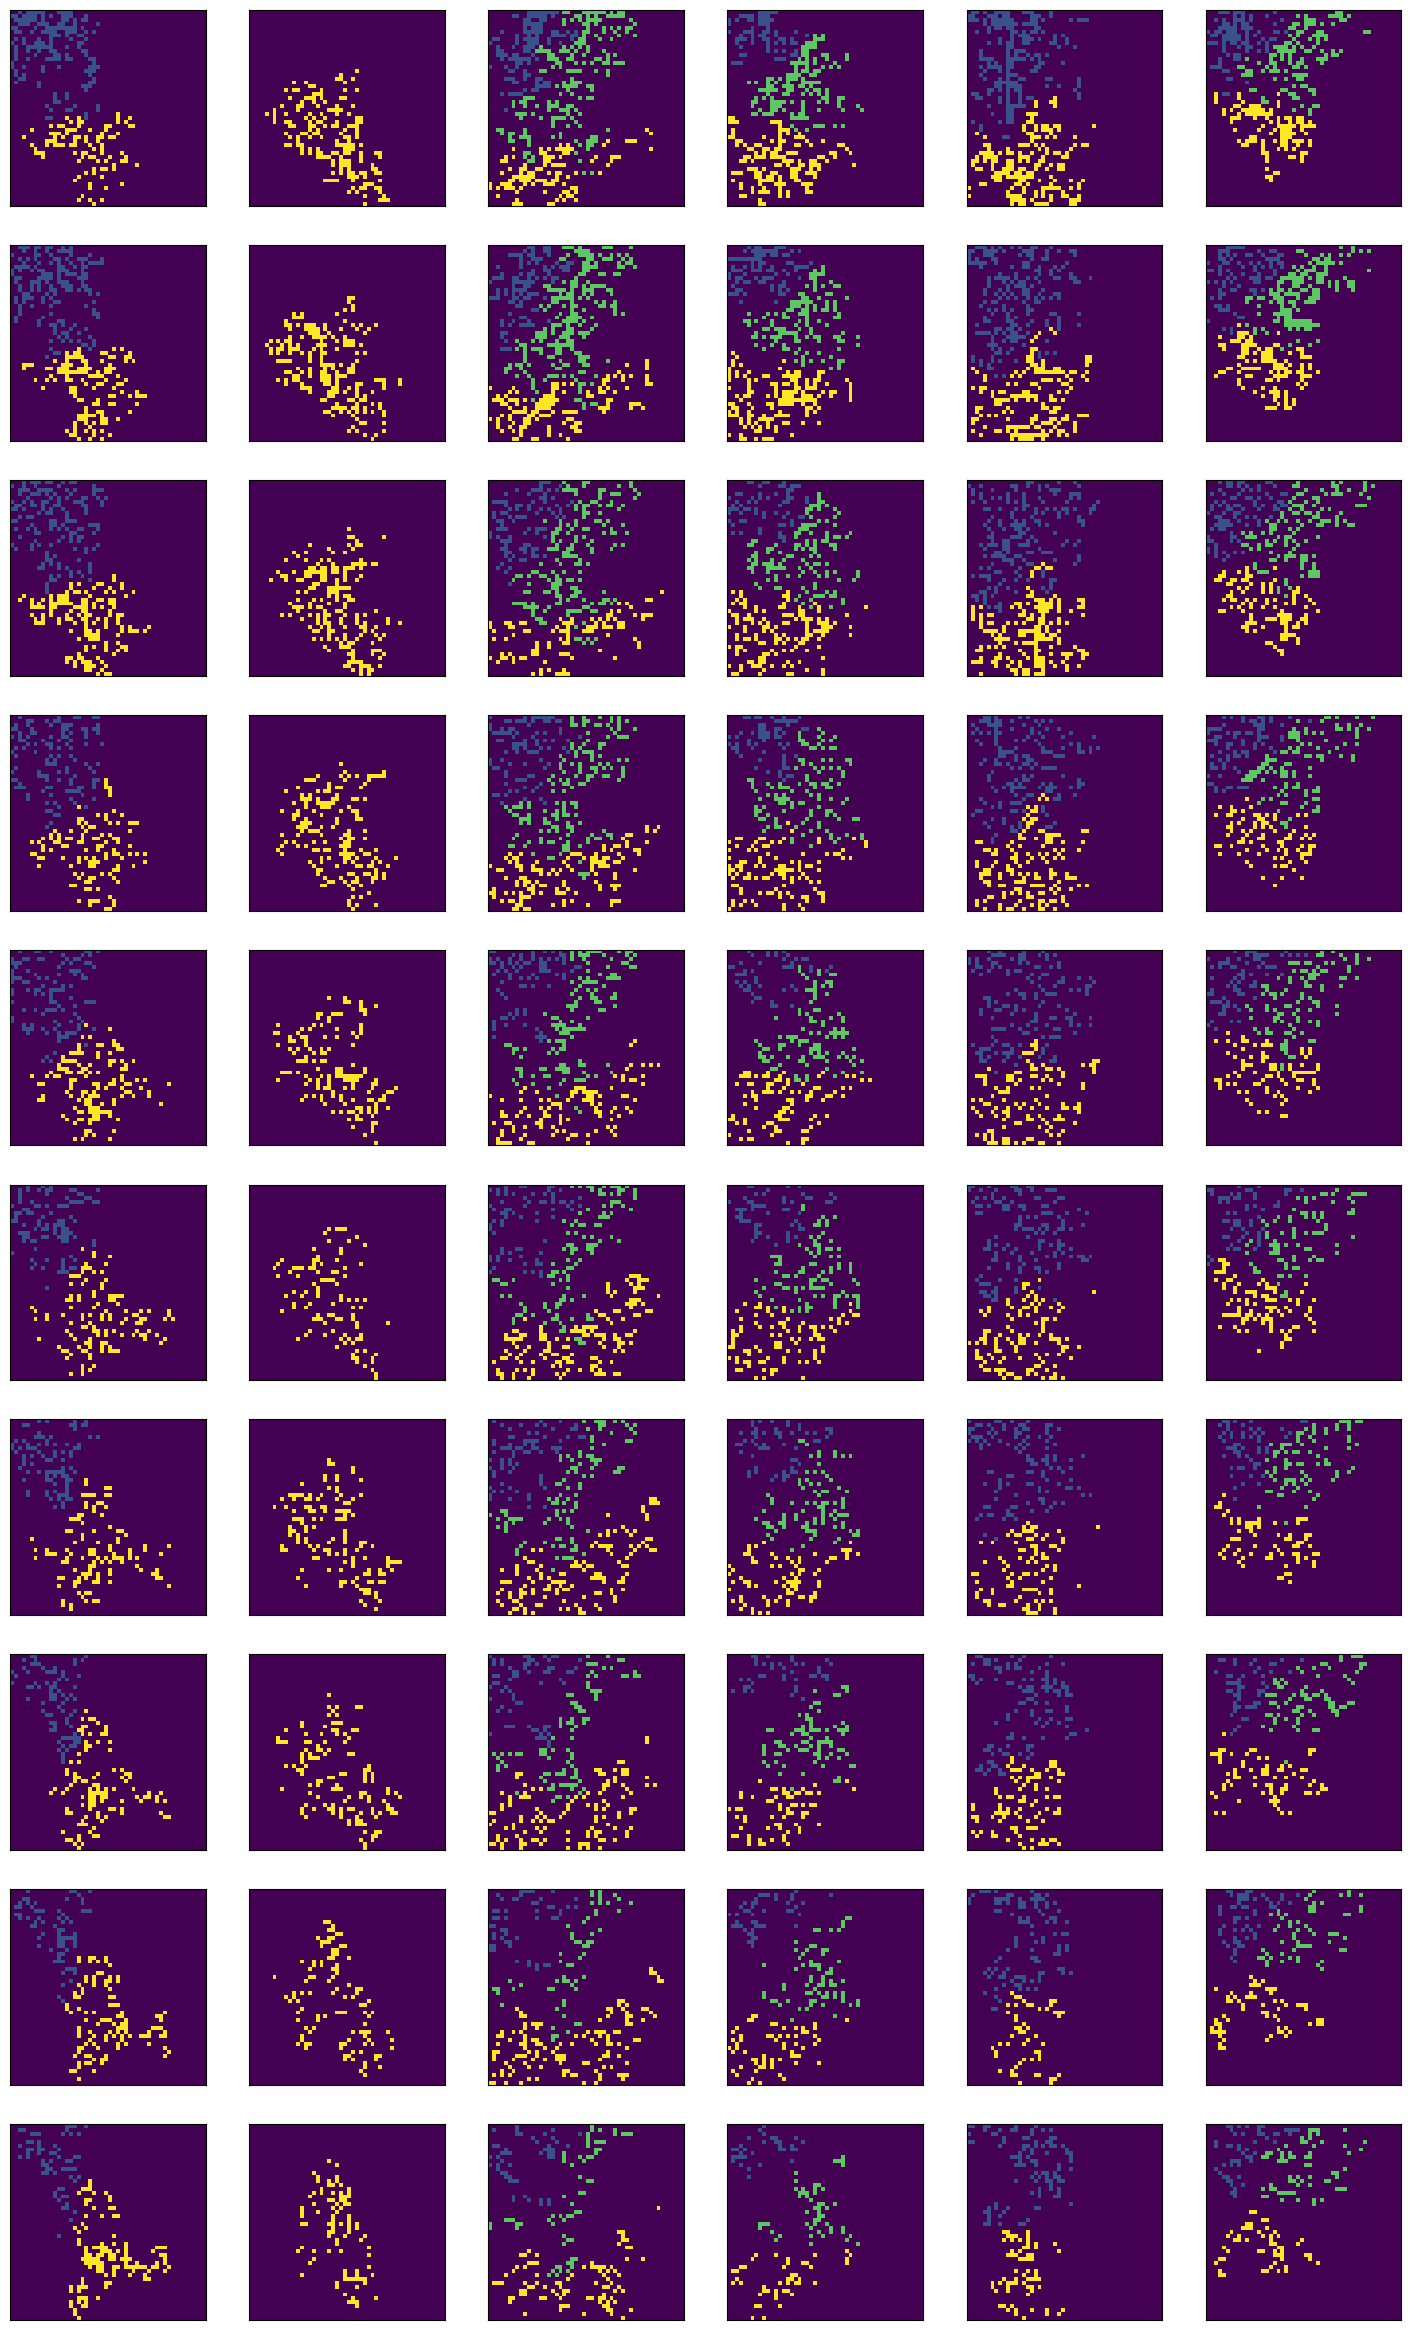

In [17]:
fig, axs = plt.subplots(bands, n_samples, figsize=(n_samples * 3, bands * 3))
for i in range(n_samples):
  for j in range(bands):
    axs[j,i].imshow(rasters[i,:,:,j])
    axs[j,i].set_yticks([])
    axs[j,i].set_xticks([])

## Example 7: 3D Solid-Color Shapes + Dilation

In [18]:
dilations = np.array([ndimage.grey_dilation(raster, size=(2, 2, 2), structure=np.ones((2, 2, 2))) for raster in rasters])

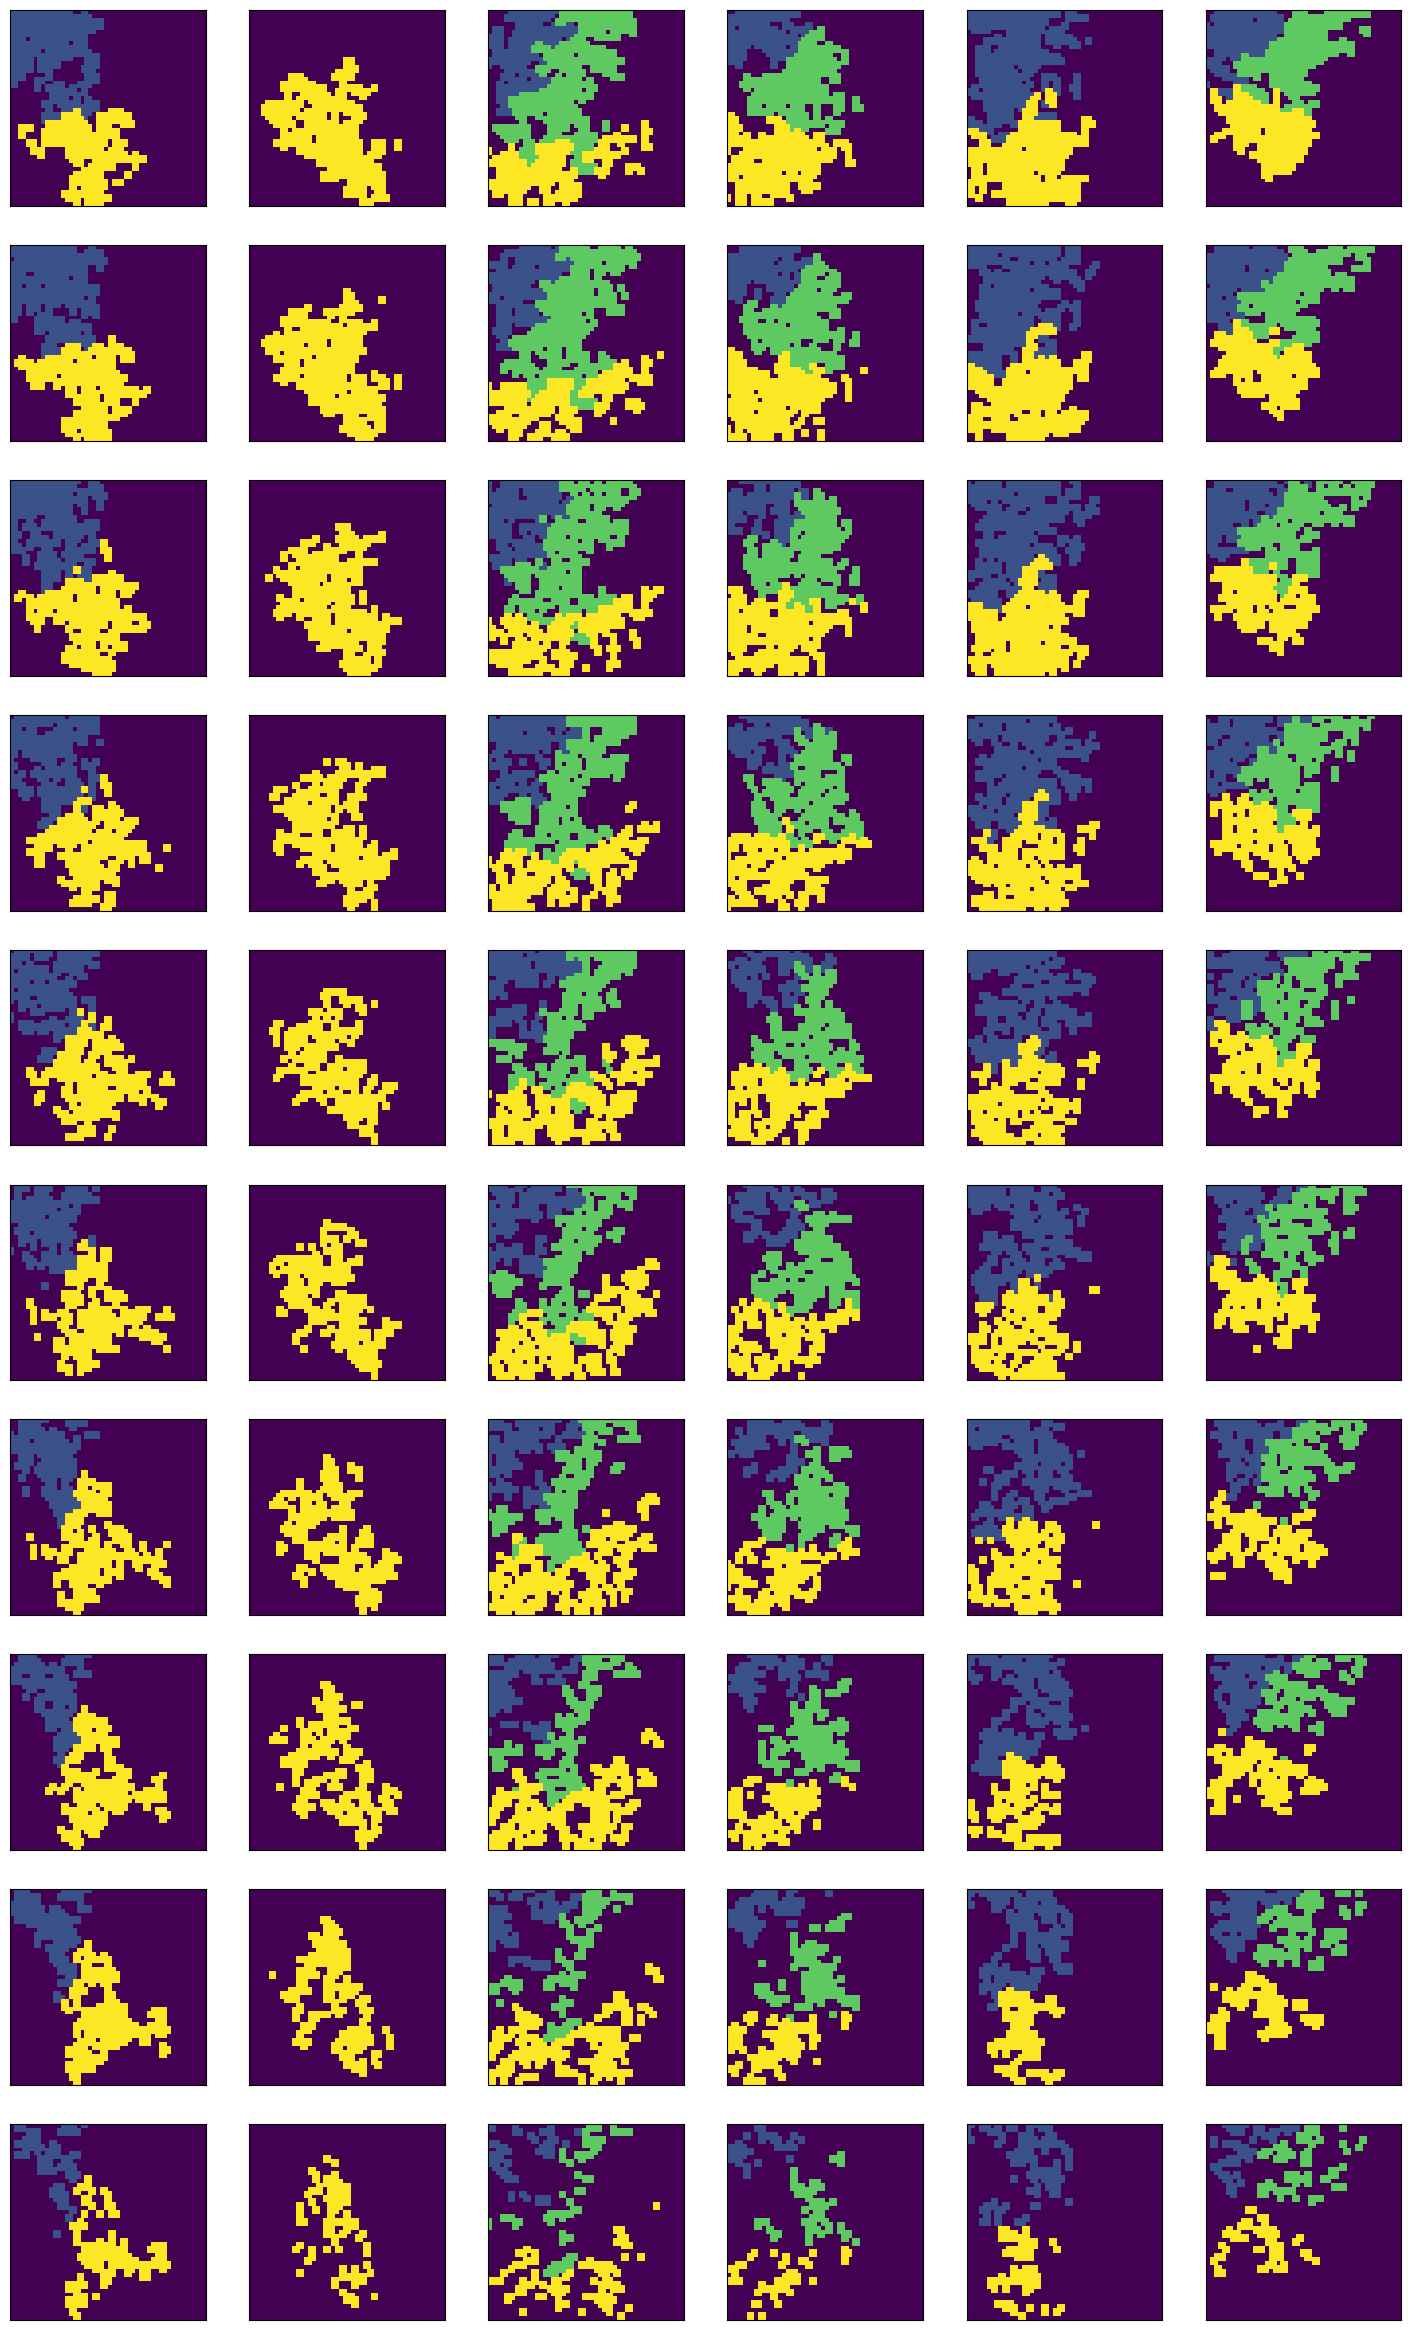

In [19]:
fig, axs = plt.subplots(bands, n_samples, figsize=(n_samples * 3, bands * 3))
for i in range(n_samples):
  for j in range(bands):
    axs[j,i].imshow(dilations[i,:,:,j])
    axs[j,i].set_yticks([])
    axs[j,i].set_xticks([])

## Example 8: 3D Fuzzy-Color Shapes

In [20]:
rasters = np.zeros((n_samples, rows, cols, bands))
for i in range(n_samples):
  mask = rasters[i].copy()
  for seed in seeds:
    grow(rasters[i], mask, seed["coords"], seed["threshold"], seed["decay"], seed["value"], seed["value_dist"])

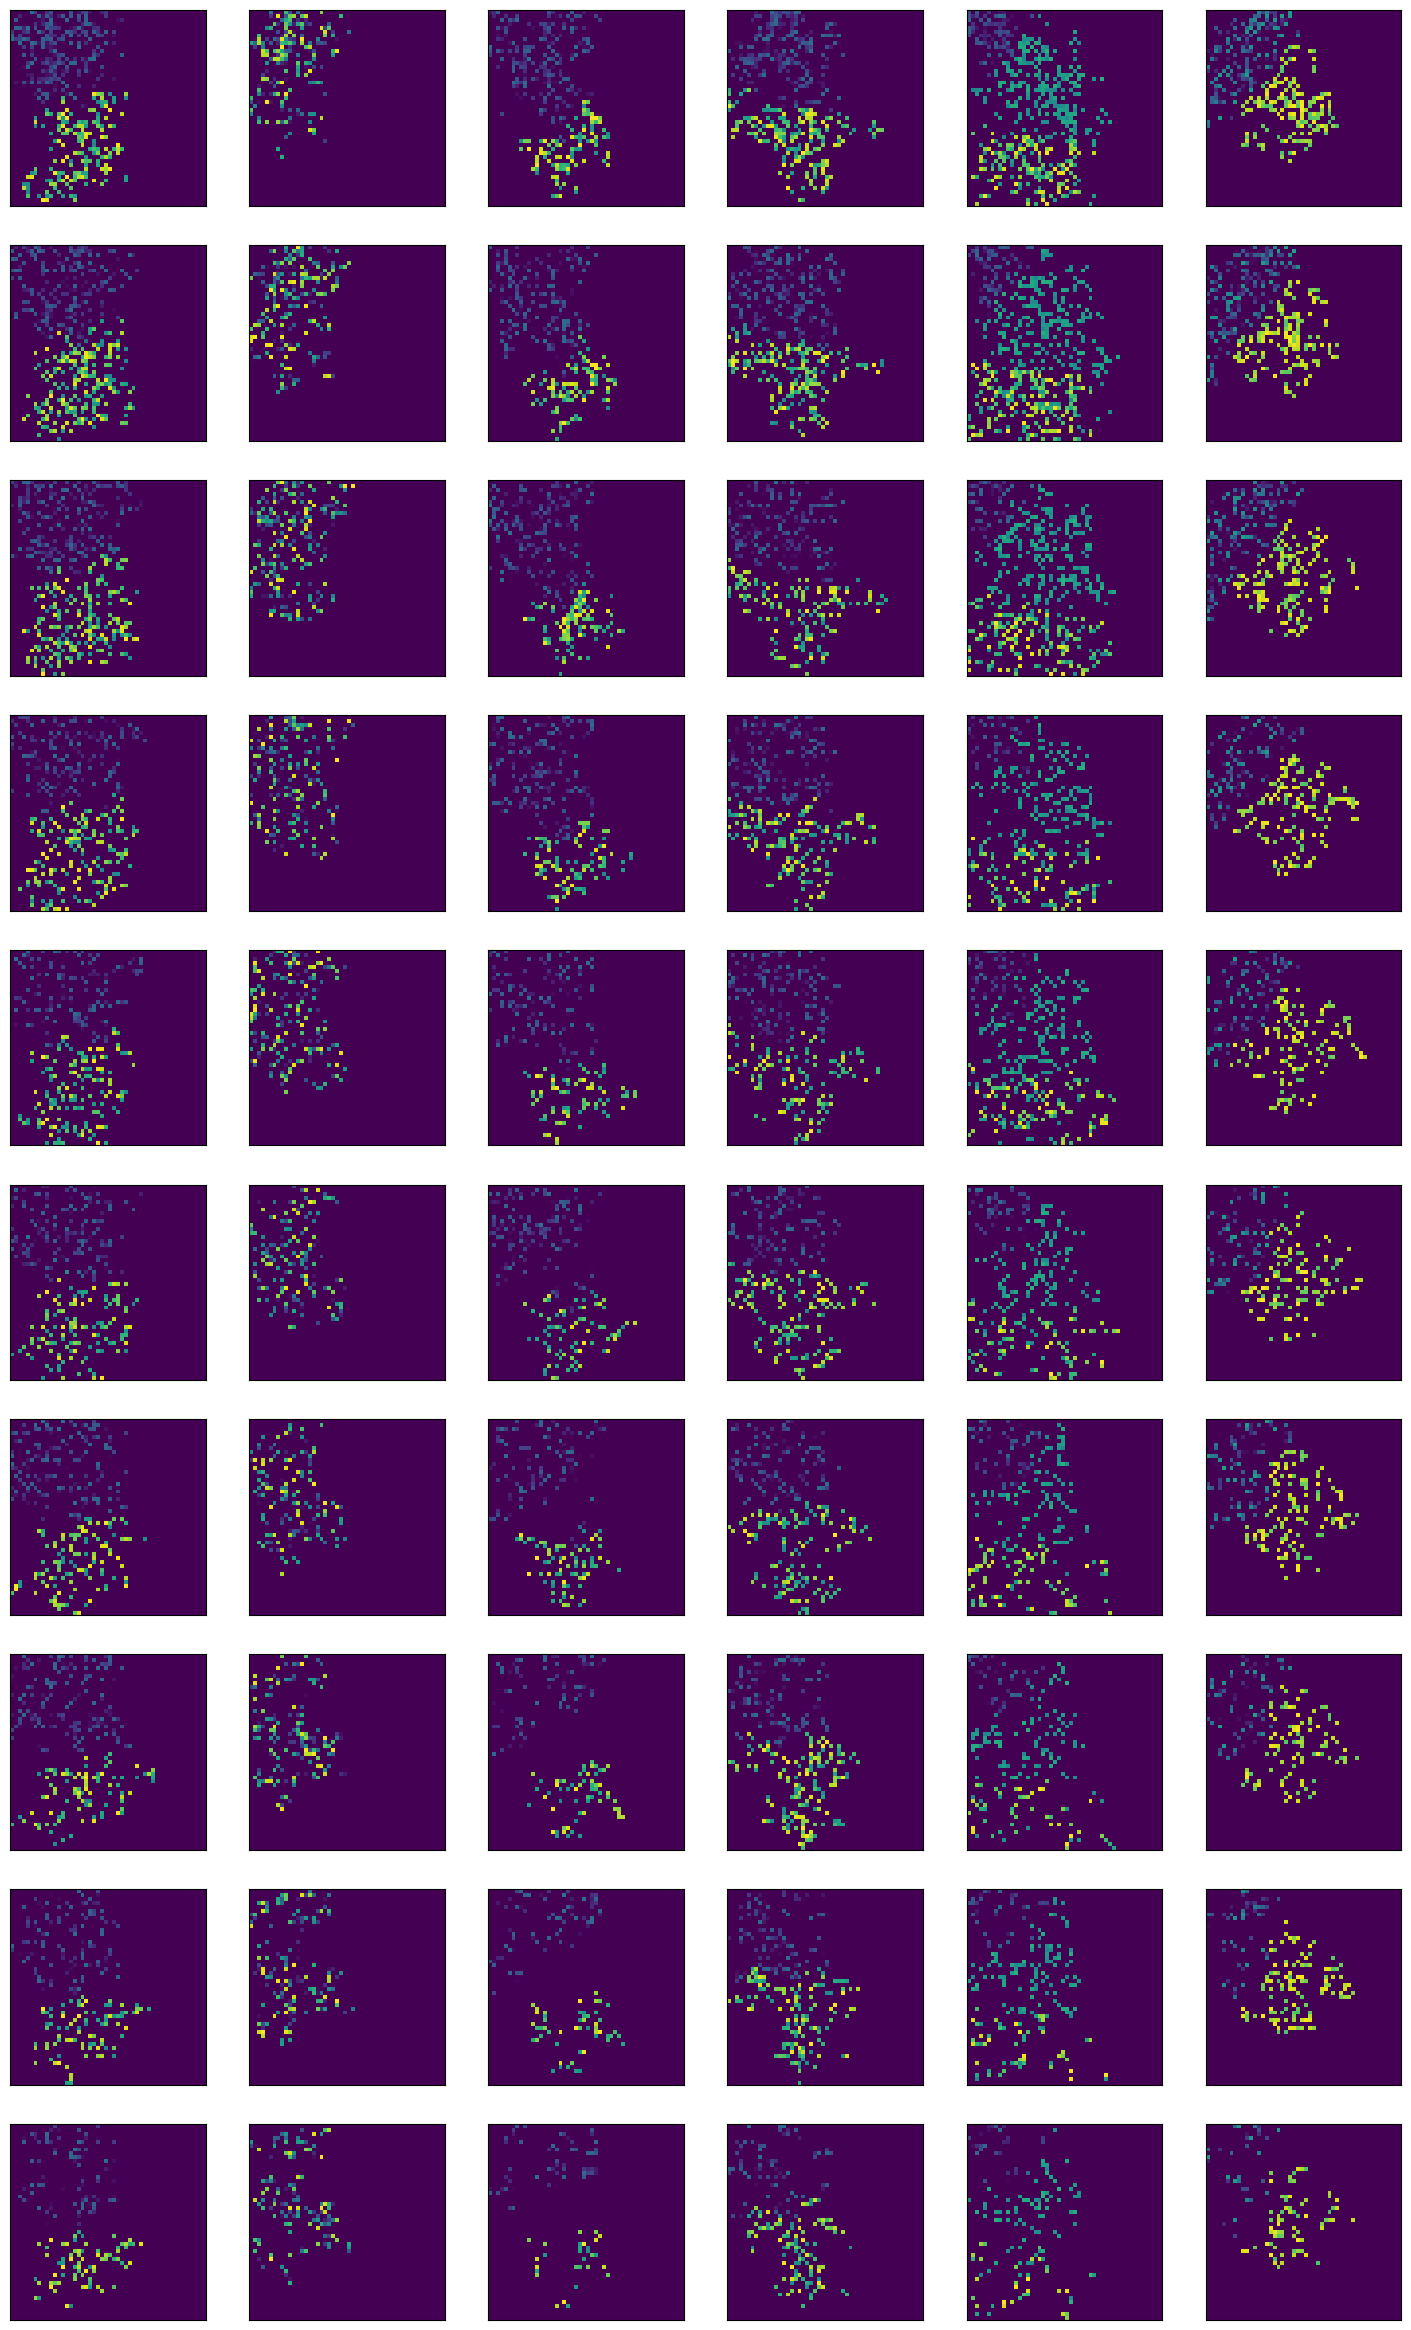

In [21]:
fig, axs = plt.subplots(bands, n_samples, figsize=(n_samples * 3, bands * 3))
for i in range(n_samples):
  for j in range(bands):
    axs[j,i].imshow(rasters[i,:,:,j])
    axs[j,i].set_yticks([])
    axs[j,i].set_xticks([])

## Example 8: 3D Fuzzy-Color Shapes + Guassian

In [22]:
guassians = np.array([ndimage.gaussian_filter(raster, sigma=0.75) for raster in rasters])

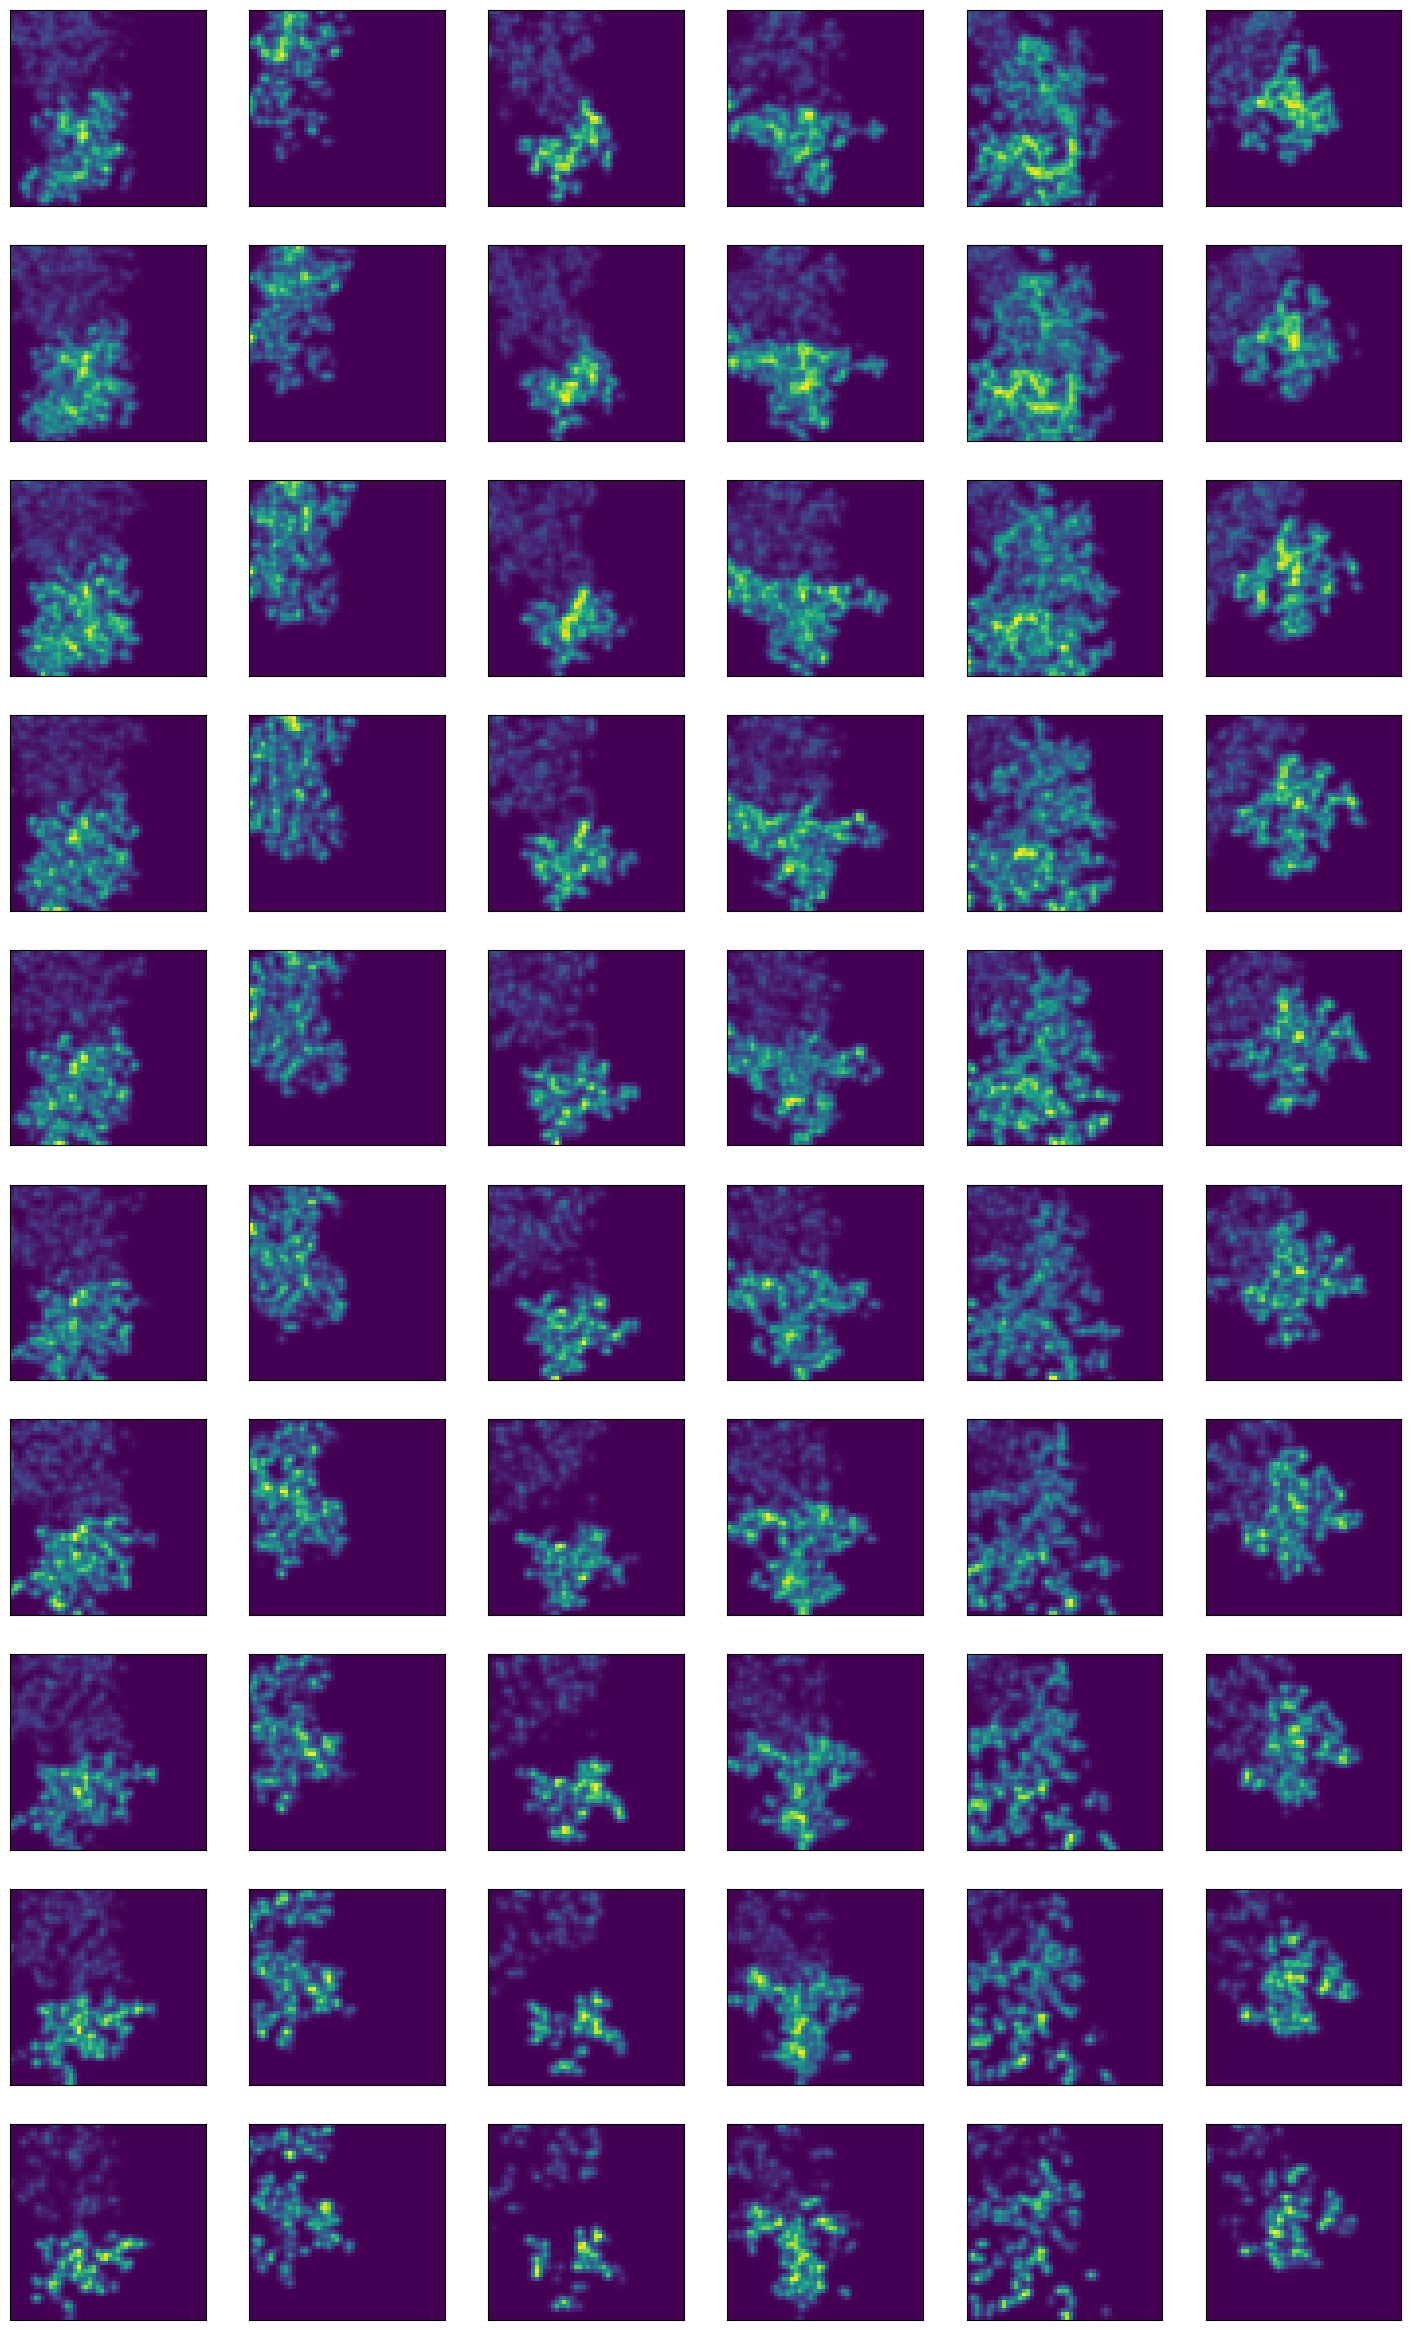

In [23]:
fig, axs = plt.subplots(bands, n_samples, figsize=(n_samples * 3, bands * 3))
for i in range(n_samples):
  for j in range(bands):
    axs[j,i].imshow(guassians[i,:,:,j])
    axs[j,i].set_yticks([])
    axs[j,i].set_xticks([])